The chosen modeling has two aspects:
- a primary model, whose goal is to predict matches final issue (home, away or draw)
- secondary models, whose goals are to predict the number of goals scored by home and away teams knowing the match final issue

This notebooks focuses on the primary model, and has the following sections:
- feature engineering
- feature selection
- fitting
- model evaluation

In [26]:
import pandas as pd
import numpy as np
import optuna
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_path)

from src.config import load_config
from src.feature_engineering import create_diff_features
from src.feature_selection import find_highly_correlated_cols, remove_low_variance_features, select_top_features

# config.yaml importation
config_file = 'config.yaml'
config_path = os.path.join(root_path, config_file)
config = load_config(config_path)

# Preprocessed data importation

In [27]:
preprocessed_data_path = os.path.join(root_path, config['preprocessed_dir'])
df_train_path = os.path.join(preprocessed_data_path, f"{config['preprocessed_train_df_name']}.csv")
df_test_path = os.path.join(preprocessed_data_path, f"{config['preprocessed_test_df_name']}.csv")

df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)
df_train.head()

,date,season,home,away,nb_goals_home,nb_goals_away,final_result,odd_home,odd_away,odd_draw,...,strict_rel_recent_nb_goals_conceded_by_match_home_team,strict_rel_recent_nb_goals_conceded_by_match_away_team,strict_rel_recent_goal_difference_home_team,strict_rel_recent_goal_difference_away_team,strict_rel_recent_percentage_victory_home_team,strict_rel_recent_percentage_victory_away_team,hist_nb_seasons_l1_home_team,hist_nb_seasons_l1_away_team,promoted_home_team,promoted_away_team
0,2010-08-07,2010/2011,Auxerre,Lorient,2.0,2.0,draw,1.971247,4.312213,3.288536,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,11,0,0
1,2010-08-07,2010/2011,Lens,Nancy,1.0,2.0,away,2.134104,3.790785,3.185679,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6,4,0,0
2,2010-08-07,2010/2011,Lyon,Monaco,0.0,0.0,draw,1.591247,7.333642,3.985679,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14,12,0,0
3,2010-08-07,2010/2011,Marseille,Caen,1.0,2.0,away,1.436961,9.797928,5.349965,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14,7,0,0
4,2010-08-07,2010/2011,Nice,Valenciennes,0.0,0.0,draw,2.148390,3.712213,3.214250,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14,4,0,0


In [28]:
primary_target = config['final_result_column']
secondary_target_home = config['nb_goals_home_column']
secondary_target_away = config['nb_goals_away_column']

X_train = df_train.drop(columns=[primary_target, secondary_target_home, secondary_target_away, config['date_column'], config['season_column']])
X_test = df_test.drop(columns=[primary_target, secondary_target_home, secondary_target_away, config['date_column'], config['season_column']])

y_train_primary = df_train[primary_target]
y_test_primary = df_test[primary_target]

In [29]:
X_train.columns

Index(['home', 'away', 'odd_home', 'odd_away', 'odd_draw',
       'current_season_points_home_team', 'current_season_points_away_team',
       'current_season_general_ranking_home_team',
       'current_season_general_ranking_away_team',
       'current_season_nb_goals_scored_home_team',
       'current_season_nb_goals_scored_away_team',
       'current_season_nb_goals_conceded_home_team',
       'current_season_nb_goals_conceded_away_team',
       'current_season_goal_difference_home_team',
       'current_season_goal_difference_away_team',
       'current_season_attack_ranking_home_team',
       'current_season_attack_ranking_away_team',
       'current_season_defense_ranking_home_team',
       'current_season_defense_ranking_away_team',
       'current_season_nb_points_home_team_at_home',
       'current_season_nb_points_away_team_away',
       'current_season_home_team_ranking_at_home',
       'current_season_away_team_ranking_away',
       'current_season_nb_goals_scored_home_team

# Feature engineering

Since we want to model the final issue of a match, exhaustive data related to home and away teams is not necessary. That is why for each pair of similar columns for home and away teams, we create the difference between these two columns.

In [30]:
patterns = [
        ("_home_team_ranking_at_home", "_away_team_ranking_away"),
        ("_home_team_at_home", "_away_team_away"),
        ("_home_team", "_away_team"),
        ("_at_home", "_away"),
        ("_home", "_away")
]

X_train_primary = create_diff_features(X_train, patterns=patterns)
X_test_primary = create_diff_features(X_test, patterns=patterns)

X_train_primary.head()

,home,away,odd_home,odd_away,odd_draw,diff_current_season,diff_current_season_nb_points,diff_current_season_nb_goals_scored,diff_current_season_nb_goals_conceded,diff_current_season_points,...,diff_rel_recent_nb_goals_conceded_by_match,diff_rel_recent_goal_difference,diff_rel_recent_percentage_victory,diff_strict_rel_recent_nb_points_by_match,diff_strict_rel_recent_nb_goals_scored_by_match,diff_strict_rel_recent_nb_goals_conceded_by_match,diff_strict_rel_recent_goal_difference,diff_strict_rel_recent_percentage_victory,diff_hist_nb_seasons_l1,diff_promoted
0,Auxerre,Lorient,1.971247,4.312213,3.288536,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8,0
1,Lens,Nancy,2.134104,3.790785,3.185679,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
2,Lyon,Monaco,1.591247,7.333642,3.985679,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
3,Marseille,Caen,1.436961,9.797928,5.349965,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0
4,Nice,Valenciennes,2.148390,3.712213,3.214250,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0


# Feature Selection

We implemented 3 methods to select features:
- remove highly correlated features
- remove low variance features
- select top K features which could explain the primary target

## Correlation method

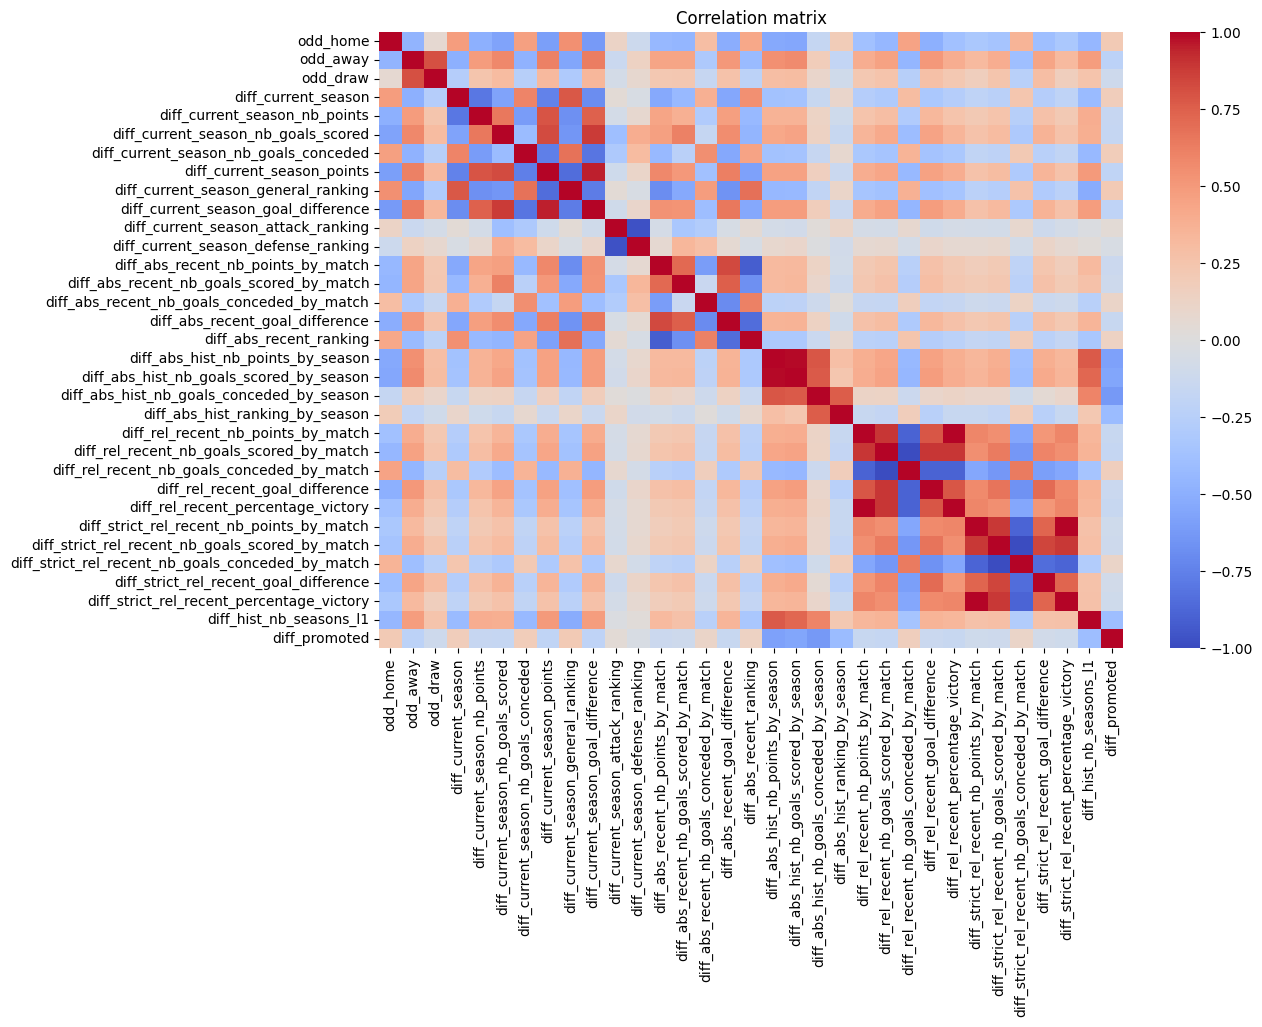

In [31]:
corr = X_train_primary.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()

In [32]:
highly_correlated_cols = find_highly_correlated_cols(X_train_primary)
highly_correlated_cols

['diff_abs_hist_nb_goals_scored_by_season',
 'diff_current_season_attack_ranking',
 'diff_strict_rel_recent_nb_goals_conceded_by_match',
 'diff_strict_rel_recent_nb_points_by_match',
 'diff_rel_recent_nb_goals_conceded_by_match',
 'diff_rel_recent_nb_points_by_match']

In [33]:
X_train_primary = X_train_primary.drop(columns=highly_correlated_cols)
X_test_primary = X_test_primary.drop(columns=highly_correlated_cols)

## Low variance method

In [34]:
low_variance_cols = remove_low_variance_features(X_train_primary)
low_variance_cols

No columns removed


[]

In [35]:
X_train_primary = X_train_primary.drop(columns=low_variance_cols)
X_test_primary = X_test_primary.drop(columns=low_variance_cols)

In [36]:
X_train_primary.columns

Index(['home', 'away', 'odd_home', 'odd_away', 'odd_draw',
       'diff_current_season', 'diff_current_season_nb_points',
       'diff_current_season_nb_goals_scored',
       'diff_current_season_nb_goals_conceded', 'diff_current_season_points',
       'diff_current_season_general_ranking',
       'diff_current_season_goal_difference',
       'diff_current_season_defense_ranking',
       'diff_abs_recent_nb_points_by_match',
       'diff_abs_recent_nb_goals_scored_by_match',
       'diff_abs_recent_nb_goals_conceded_by_match',
       'diff_abs_recent_goal_difference', 'diff_abs_recent_ranking',
       'diff_abs_hist_nb_points_by_season',
       'diff_abs_hist_nb_goals_conceded_by_season',
       'diff_abs_hist_ranking_by_season',
       'diff_rel_recent_nb_goals_scored_by_match',
       'diff_rel_recent_goal_difference', 'diff_rel_recent_percentage_victory',
       'diff_strict_rel_recent_nb_goals_scored_by_match',
       'diff_strict_rel_recent_goal_difference',
       'diff_strict_re

## Top K features 

In [37]:
top_k_cols = select_top_features(X_train_primary, y_train_primary)
top_k_cols

Index(['odd_home', 'odd_away', 'odd_draw', 'diff_current_season',
       'diff_current_season_nb_points', 'diff_current_season_nb_goals_scored',
       'diff_current_season_nb_goals_conceded', 'diff_current_season_points',
       'diff_current_season_general_ranking',
       'diff_current_season_goal_difference',
       'diff_abs_recent_nb_points_by_match',
       'diff_abs_recent_nb_goals_scored_by_match',
       'diff_abs_recent_goal_difference', 'diff_abs_recent_ranking',
       'diff_abs_hist_nb_points_by_season',
       'diff_rel_recent_nb_goals_scored_by_match',
       'diff_rel_recent_goal_difference', 'diff_rel_recent_percentage_victory',
       'diff_strict_rel_recent_goal_difference', 'diff_hist_nb_seasons_l1'],
      dtype='object')

In [38]:
# Optional: only select these top k features
# X_train_primary = X_train_primary[top_k_cols]
# X_test_primary = X_test_primary[top_k_cols]

# Fitting

Three types of models will be tested:
- logistic regression
- random forest
- XGBoost

## Logistic regression

## Evaluation

# Final model storage